# Make Transects

This notebook illustrates how to transects of event results or hazard maps.


### First set up some things needed in notebook....

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import sys, os
from ptha_paths import data_dir, events_dir

Assuming that top level of this repository is at: /Users/rjl/ptha_tutorial
    Python codes can be found in codes_dir = /Users/rjl/ptha_tutorial/PythonCode
    Data files can be found in data_dir = /Users/rjl/ptha_tutorial/DataFiles
    Results for each event can be found in events_dir = /Users/rjl/ptha_tutorial/DataFiles/Events


### Read in the topography data and define a function to make a contour plot:

In [7]:
# Read in topography data:

fixed_grid_file = os.path.join(data_dir, 'MapsTopo', 'fixedgrid_xyB_small.npy')
d=load(fixed_grid_file)
x=d[:,0]
y=d[:,1]
B=d[:,2]
topo = reshape(B, (250,250), order='F')
X = reshape(x, (250,250), order='F')
Y = reshape(y, (250,250), order='F')

def plot_topo():
    fig = figure(figsize=(6,6))
    ax = axes()
    topo_clines = arange(0,20,2)
    contour(X,Y,topo,topo_clines,colors='k')
    CClatitude = 41.75  # to rescale longitude
    ax.set_aspect(1. / cos(pi*CClatitude/180.)) 
    ax.ticklabel_format(format='plain',useOffset=False)


### Read in image of Crescent City as background for plots

In [8]:
CCmap = imread('%s/MapsTopo/CCimage.png' % data_dir)
extent = (235.79781, 235.82087, 41.739671,41.762726)   #small region

def plot_CCmap():
    fig = figure(figsize=(6,6))
    ax = axes()
    imshow(CCmap,extent=extent)
    CClatitude = 41.75  # to rescale longitude
    ax.set_aspect(1. / cos(pi*CClatitude/180.)) 
    ax.ticklabel_format(format='plain',useOffset=False)
    axis(extent)


## Define `plot_transect` function

We first define a function `topo_func` that allows us to evaluate the topography at any point `(x,y)`.

The function `plot_transect` is then defined to take two points `(x1,y1)` and `(x2,y2)` and interpolate the topography onto a set of 1000 equally spaced points along the transect (straight line connecting the points).  The function also takes another argument, a `z_func` function that can also be evaluated at any point and is assumed to return a value of $\zeta$ at this point.  This might be defined to be the `zeta` for a particular single event, or it might be the `zeta` coming from a probabilistic analysis at some particular probability `p`.  


In [9]:
from scipy.interpolate import RegularGridInterpolator
topo_func = RegularGridInterpolator((X[:,0], Y[0,:]), topo)

def plot_transect(x1,y1, x2,y2, z_func):
    
    # points on transect:
    xi = linspace(x1, x2, 1000)
    yi = linspace(y1, y2, 1000)
    
    # plot the transect on top of topography:
    fig = plot_topo()
    plot([x1,x2], [y1,y2], 'r-', linewidth=3)
    title('Transect')

    # evaulate topo and zeta on transect:
    Bi = topo_func(zip(xi,yi))
    zi = z_func(zip(xi,yi))
    
    # define eta as zeta offshore or zeta + topo onshore:
    eta = where(Bi<0, zi, zi+Bi)
    
    # plot cross sections on topo
    # plot vs. longitude or latitude depending on orientation:
    
    if (abs(x2-x1) > 0.5*abs(y2-y1)):
        ti = xi
        xtext = 'longitude'
    else:
        ti = yi
        xtext = 'latitude'
        
    Bi0 = where(Bi<0, 0., Bi)
    
    figure(figsize=(15,4))
    fill_between(ti, Bi0, eta, color='b')
    plot(ti, Bi, 'g')
    
    xlabel(xtext)
    ylabel('meters')
    plt.title('Elevation vs. %s' % xtext)
    
    # choose limits of vertical axis to give nice plots:
    eta_wet_max = where(zi>0, zi+Bi, 0).max()
    ylim(-2, max(6,eta_wet_max))
    
    ticklabel_format(format='plain',useOffset=False)
    plt.xticks(rotation=20)

### Illustrate use of this function for a single event

We can read in the `zeta` file for a single event and plot it along any transect as illustrated below.

First we read in this event and compute the interpolating function, here called `zeta_event_func`.

In [10]:
event = 'AASZb'
event_dir = os.path.join(events_dir, event)
hmax_file = os.path.join(event_dir, 'h_eta_small.npy')
hmax = load(hmax_file)
Hmax = hmax.reshape((250,250),order='F')
zeta_event_func = RegularGridInterpolator((X[:,0], Y[0,:]), Hmax)

Next set the transect end points and plot using the `plot_transect` function defined above.

Event: AASZb


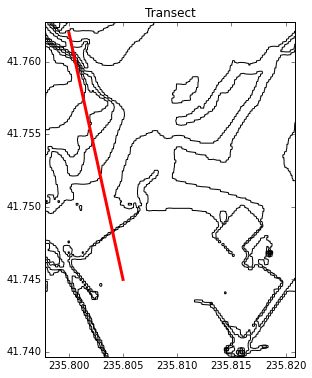

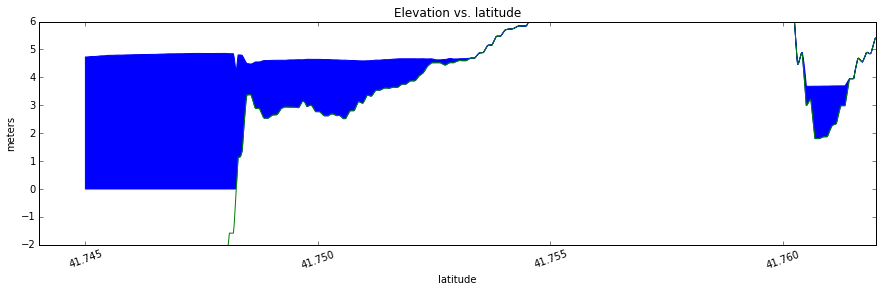

In [12]:
x1 = 235.805;  y1 = 41.745
x2 = 235.800;  y2 = 41.762

print("Event: %s" % event)
plot_transect(x1,y1, x2,y2, zeta_event_func)

Try changing the transect and re-executing the cell above.  For example, you might try:
```
x1 = 235.812;  y1 = 41.741
x2 = 235.820;  y2 = 41.762
```

Next try changing the event, e.g. set
```
event = 'CSZb'
```
two cells above (to recompute `zeta_event_func`), and then re-execute that cell and the one that plots the transect.

# Transects of probability of exceedance

The next several cells are duplicated from `Make_Hazard_Curves_and_Maps.ipynb` to calculate an array `exceed_prob` and a function `compute_zeta(p)` that returns `zeta` at all points on the grid for a given probability `p`. 

### Set the exceedance values

This should be a list or array of values $\zeta$ (`zeta`) representing depth of flooding on shore, or elevation above sea level offshore (in meters).  The hazard curves will be computed by determining the annual probability that the maximum $\zeta$ observed at each spatial point is above $\zeta_k$, for each value $\zeta_k$ in this list.

In [13]:
zeta = hstack((arange(0,2.,.1), arange(2.0,12.5,.5)))
nzeta = len(zeta)
print '%i exceedance values, \nzeta =  %s' % (nzeta,zeta)

41 exceedance values, 
zeta =  [  0.    0.1   0.2   0.3   0.4   0.5   0.6   0.7   0.8   0.9   1.    1.1
   1.2   1.3   1.4   1.5   1.6   1.7   1.8   1.9   2.    2.5   3.    3.5
   4.    4.5   5.    5.5   6.    6.5   7.    7.5   8.    8.5   9.    9.5
  10.   10.5  11.   11.5  12. ]


### Set the desired annual probability for each event

Note that we are only using 14 events for this workshop.  The probabilities have been adjusted accordingly.

`event_prob` is a Python dictionary. It is inialized to an empty dictionary and then we set `event_prob[key] = value` where the keys are the names of the hypothetical events and the associated value is the annual probability.

In [14]:
all_events = ['AASZa', 'AASZb', 'AASZc', 'AASZd', 'CSZa', 'CSZb', 'CSZc', 'CSZd', 'CSZe', \
              'CSZf', 'KmSZa', 'KrSZa', 'SChSZa', 'TOHa']

event_prob = {}
event_prob['AASZa'] = 1./394.
event_prob['AASZb'] = 1./750.
event_prob['AASZc'] = 1./563.
event_prob['AASZd'] = 1./324.
event_prob['CSZa'] = 1./250. * .0125
event_prob['CSZb'] = 1./250. * .0125
event_prob['CSZc'] = 1./250. * .0750
event_prob['CSZd'] = 1./250. * .5000
event_prob['CSZe'] = 1./250. * .1750
event_prob['CSZf'] = 1./250. * .2250
event_prob['KmSZa'] = 1./50.
event_prob['KrSZa'] = 1./167.
event_prob['SChSZa'] = 1./300.
event_prob['TOHa'] = 1./103.

print "Annual probability of each event is set to:"
print event_prob

Annual probability of each event is set to:
{'AASZb': 0.0013333333333333333, 'AASZc': 0.0017761989342806395, 'AASZa': 0.0025380710659898475, 'SChSZa': 0.0033333333333333335, 'AASZd': 0.0030864197530864196, 'KrSZa': 0.005988023952095809, 'TOHa': 0.009708737864077669, 'KmSZa': 0.02, 'CSZa': 5e-05, 'CSZb': 5e-05, 'CSZc': 0.0003, 'CSZd': 0.002, 'CSZe': 0.0007, 'CSZf': 0.0009000000000000001}


### Define a function to combine two events

In [15]:
def combine_prob(p1,p2):
    """Returns the probability that event 1 or 2 happens"""
    return 1. - (1-p1)*(1-p2)

### Specify the set of events to include in computing hazard curves:

In [16]:
events = all_events

# Instead, to use a subset of the events, specify a list such as:
#events = ['AASZa', 'AASZb', 'AASZc']

### Compute the combined probability of exceeding each exceedance value:

`exceed_prob` is computed as an array of shape 

In [17]:
nx, ny = X.shape  # note that X is a 2d array of longitude values at each point
exceed_prob = zeros((nx,ny,nzeta))  # initialize to zero

# loop over all events and update exceed_prob at each grid point by combining
# current value with the probability Pk of this event:

for event in events:
    event_dir = os.path.join(events_dir, event)
    hmax_file = os.path.join(event_dir, 'h_eta_small.npy')
    hmax = load(hmax_file)
    Hmax = hmax.reshape((nx,ny),order='F')
    for k in range(nzeta):
        Pk = exceed_prob[:,:,k]  # probabilities at all points for one exceedance value zeta_k
        exceed_prob[:,:,k] = where(Hmax > zeta[k], combine_prob(event_prob[event],Pk), Pk)
        
print "Computed exceedance probabilities.  \nMaximum over all grid points is %g" % exceed_prob.max()

Computed exceedance probabilities.  
Maximum over all grid points is 0.0507195


### Function to compute `zeta` for any `p`:

**Note:** The functions `compute_zeta` defined in the cell below uses the exceedance probabilities `exceed_prob` computed above.  If you recompute these (e.g. by changing the set of events to include, or the probabilities of individual events), you must re-execute this cell to redefine the function before re-making the plots in later cells!

In [18]:
def compute_zeta(p):

    # create boolean array K with K[i,j,k] == True only where exceed_prob[i,j,k] > p:
    K = exceed_prob > p

    K[:,:,0] = True
    zeta_p = zeros(X.shape)
    for i in range(nx):
        for j in range(ny):
            zeta_p[i,j] = zeta[K[i,j,:]][-1]
    return zeta_p


# Transects

Now we can plot transects for a given probability $p$, e.g. $p=0.002$ for the "500-year flood".  Experiment with changing `p` or the transect...


In [19]:
p = 0.002
zeta_p = compute_zeta(p)
zeta_p_func = RegularGridInterpolator((X[:,0], Y[0,:]), zeta_p)

Transect of zeta for given annual probability p = 0.002


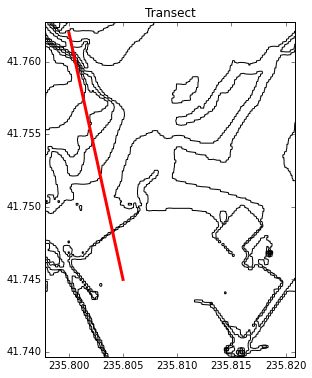

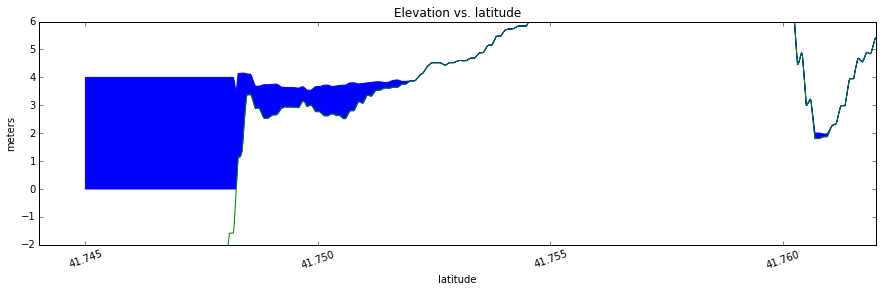

In [20]:
# Set endpoints of transect:
x1 = 235.805;  y1 = 41.745
x2 = 235.800;  y2 = 41.762

print "Transect of zeta for given annual probability p = %g" % p
plot_transect(x1,y1, x2,y2, zeta_p_func)

The notebook [Make_Transects_interactive.ipynb](Make_Transects_interactive.ipynb) shows how to 
interact with a map and create a transect on the fly.
